In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

from scipy.stats import mode 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

import math

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data_dir = '../../../data/processed/Distrito_QRO/'

In [3]:
# hex_cluster = gpd.read_file('../data/processed/hex_clusters.geojson')

In [4]:
# hex_cluster.groupby('cluster').agg(['mean','median','std','count']).to_csv('../data/processed/cluster_stats.csv')

In [5]:
# hex_cluster.groupby('cluster').agg('mean','median','std').to_csv('../data/processed/cluster_stats_mean.csv')

In [6]:
hex_socio = gpd.read_file(f'{data_dir}hex_sociodemographic.geojson')
hex_eco = gpd.read_file(f'{data_dir}hex_economic.geojson')
hex_infra = gpd.read_file(f'{data_dir}hex_infraestructura.geojson')
hex_env = gpd.read_file(f'{data_dir}hex_environmental.geojson')
# hex_con = gpd.read_file(f'{data_dir}hex_connectivity.geojson')
hex_us = gpd.read_file(f'{data_dir}hex_urban_structure.geojson')
hex_prox = gpd.read_file(f'{data_dir}hex_proximity.geojson')

## Data treatment

In [7]:
hex_gdf = hex_eco[['hex_id_9','geometry']].copy()
print(hex_gdf.shape)
hex_gdf.head(2)

(2826, 2)


,hex_id_9,geometry
0,8949822402fffff,"POLYGON ((-100.2089 20.74718, -100.20765 20.74..."
1,89498224103ffff,"POLYGON ((-100.22424 20.75045, -100.223 20.752..."


#### Filter

In [8]:
# hex_filter = gpd.read_file(f'{data_dir}hex_filter.geojson')
# hex_gdf = hex_gdf.loc[hex_gdf.hex_id_9.isin(list(hex_filter.hex_id_9.unique()))]
# print(hex_gdf.shape)
# hex_gdf.head(2)

#### Spatial filter

In [9]:
gdf = gpd.read_file(f'{data_dir}PoligonoEstudio_DistritoQRO_GCS_v1.geojson')
gdf['geometry'] = gdf.to_crs("EPSG:32614").buffer(1500)
gdf = gdf.to_crs("EPSG:4326")
hex_clip = gpd.clip(hex_gdf, gdf)
hex_gdf = hex_gdf.loc[hex_gdf.hex_id_9.isin(list(hex_clip.hex_id_9.unique()))]
print(hex_gdf.shape)
hex_gdf.head(2)

(351, 2)


,hex_id_9,geometry
474,894983c120bffff,"POLYGON ((-100.43583 20.61766, -100.43459 20.6..."
478,894983c121bffff,"POLYGON ((-100.43624 20.61428, -100.435 20.615..."


In [10]:
hex_socio = hex_socio.loc[hex_socio.hex_id_9.isin(list(hex_gdf.hex_id_9))].copy()
hex_eco = hex_eco.loc[hex_eco.hex_id_9.isin(list(hex_gdf.hex_id_9))].copy()
hex_infra = hex_infra.loc[hex_infra.hex_id_9.isin(list(hex_gdf.hex_id_9))].copy()
hex_env = hex_env.loc[hex_env.hex_id_9.isin(list(hex_gdf.hex_id_9))].copy()
# hex_con = gpd.read_file(f'{data_dir}hex_connectivity.geojson')
hex_us = hex_us.loc[hex_us.hex_id_9.isin(list(hex_gdf.hex_id_9))].copy()
hex_prox = hex_prox.loc[hex_prox.hex_id.isin(list(hex_gdf.hex_id_9))].copy()

### Sociodemographic

In [11]:
hex_socio.head(2)

,hex_id_9,CVEGEO,NOMGEO,city,type,nse_idx,hex_id,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn,geometry
1031,894983c164fffff,22014,Querétaro,Queretaro,urban,0.719938,894983c164fffff,13.370000,121.525788,0.747792,0.228204,0.682472,0.089324,0.982589,"POLYGON ((-100.43209 20.59674, -100.43084 20.5..."
1032,894983ca69bffff,22014,Querétaro,Queretaro,urban,-0.291936,894983ca69bffff,10.579962,74.240933,0.421820,0.234698,0.593994,0.171307,0.953263,"POLYGON ((-100.37653 20.58776, -100.37528 20.5..."


In [12]:
hex_socio = hex_socio[['hex_id_9','nse_idx','graproes',
                       'dens_pob_ha',
                       'auto_viv','pct_0_17','pct_18_59',
                       'pct_60_mas','wgt_imn']]
socio_cols = ['nse_idx',
              'graproes','dens_pob_ha',
                       'auto_viv','pct_0_17','pct_18_59',
                       'pct_60_mas','wgt_imn']
hex_socio = hex_socio.fillna(0)
hex_socio_std = hex_socio.copy()
hex_socio_std[socio_cols] = StandardScaler().fit_transform(np.array(hex_socio[socio_cols]))
print(hex_socio_std.shape)
hex_socio_std.head(2)

(351, 9)


,hex_id_9,nse_idx,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn
1031,894983c164fffff,0.757222,0.550993,1.651415,0.721618,0.093373,0.609432,-0.949456,0.296752
1032,894983ca69bffff,-0.723560,-0.325650,0.516722,-0.912293,0.140892,0.010011,0.141096,0.146848


In [13]:
pca = PCA(n_components=3)

x = hex_socio_std.loc[:, socio_cols].values

principalComponents = pca.fit_transform(x)

In [14]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.59510502 0.1584583  0.10080339] Explained variance: 0.8543667065714887


In [15]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc_1', 'pc_2','pc_3'])

hex_socio_pca = hex_socio[['hex_id_9']]
hex_socio_pca.loc[:,['socio_pc_1','socio_pc_2','socio_pc_3']]= np.nan, np.nan, np.nan
hex_socio_pca.loc[:,'socio_pc_1'] = principalDf['pc_1'].copy()
hex_socio_pca.loc[:,'socio_pc_2'] = principalDf['pc_2'].copy()
hex_socio_pca.loc[:,'socio_pc_3'] = principalDf['pc_3'].copy()

### Economic

In [16]:
hex_eco.head(2)

,hex_id_9,denue_count,denue_jobs,denue_0_5,denue_6_10,denue_11_30,denue_31_50,denue_51_100,denue_101_250,denue_250_mas,denue_jobs_>_11,pct_jobs_>_11,Comercio,Gubernamental,Industria,Otros,Servicios,per_ocu_tot,geometry
474,894983c120bffff,2913.015873,28336.079365,2408.190476,204.285714,173.380952,46.698413,31.746032,27.142857,21.571429,19477.222222,0.687365,0.000000,0.072254,0.905588,0.010597,0.011561,1038.0,"POLYGON ((-100.43583 20.61766, -100.43459 20.6..."
478,894983c121bffff,3237.383838,29026.969697,2715.161616,220.393939,177.333333,47.151515,31.343434,24.101010,21.898990,19118.333333,0.658640,0.554854,0.000000,0.063141,0.086030,0.295975,1267.0,"POLYGON ((-100.43624 20.61428, -100.435 20.615..."


In [17]:
hex_eco = hex_eco[['hex_id_9','denue_count','denue_jobs','denue_jobs_>_11',
                   'pct_jobs_>_11',]]
eco_cols = ['denue_count','denue_jobs','denue_jobs_>_11',
                   'pct_jobs_>_11']
hex_eco = hex_eco.fillna(0)
hex_eco_std = hex_eco.copy()
hex_eco_std[eco_cols] = StandardScaler().fit_transform(np.array(hex_eco[eco_cols]))
print(hex_eco_std.shape)
hex_eco_std.head(2)

(351, 5)


,hex_id_9,denue_count,denue_jobs,denue_jobs_>_11,pct_jobs_>_11
474,894983c120bffff,-0.175624,-0.118862,-0.046436,0.196963
478,894983c121bffff,-0.058235,-0.085673,-0.075524,-0.117070


In [18]:
pca = PCA(n_components=2)

x = hex_eco_std.loc[:, eco_cols].values

principalComponents = pca.fit_transform(x)

In [19]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.76746852 0.22498457] Explained variance: 0.9924530843990437


In [20]:
hex_eco_pca = hex_eco[['hex_id_9']]
hex_eco_pca.loc[:,['eco_pc_1','eco_pc_2',]] = np.nan, np.nan,
hex_eco_pca.loc[:,'eco_pc_1'] = principalComponents[:,0]
hex_eco_pca.loc[:,'eco_pc_2'] = principalComponents[:,1]

### Infraestructure

In [21]:
hex_infra.head(2)

,hex_id_9,CVEGEO,NOMGEO,city,type,pct_BANQUETA,pct_ALUMPUB,pct_RAMPAS,pct_ARBOLES,pct_CICLOVIA,geometry
1031,894983c164fffff,22014,Querétaro,Queretaro,urban,1.000000,0.568418,0.036509,0.747081,0.031373,"POLYGON ((-100.43209 20.59674, -100.43084 20.5..."
1032,894983ca69bffff,22014,Querétaro,Queretaro,urban,0.902017,0.896248,0.308897,0.387534,0.139579,"POLYGON ((-100.37653 20.58776, -100.37528 20.5..."


In [22]:
hex_infra = hex_infra[['hex_id_9','pct_BANQUETA','pct_ALUMPUB',
                      'pct_RAMPAS','pct_ARBOLES','pct_CICLOVIA']]
infra_cols = ['pct_BANQUETA','pct_ALUMPUB',
                      'pct_RAMPAS','pct_ARBOLES','pct_CICLOVIA']
hex_infra = hex_infra.fillna(0)
hex_infra_std = hex_infra.copy()
hex_infra_std[infra_cols] = StandardScaler().fit_transform(np.array(hex_infra[infra_cols]))
print(hex_infra_std.shape)
hex_infra_std.head(2)

(351, 6)


,hex_id_9,pct_BANQUETA,pct_ALUMPUB,pct_RAMPAS,pct_ARBOLES,pct_CICLOVIA
1031,894983c164fffff,0.661625,-0.070892,-0.676883,0.552648,-0.045390
1032,894983ca69bffff,0.240337,1.353146,0.506859,-0.810104,1.223511


In [23]:
pca = PCA(n_components=3)

x = hex_infra_std.loc[:, infra_cols].values

principalComponents = pca.fit_transform(x)

In [24]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.42552492 0.2374762  0.13938278] Explained variance: 0.8023839076362147


In [25]:
hex_infra_pca = hex_infra[['hex_id_9']]
hex_infra_pca.loc[:,['infra_pc_1','infra_pc_2','infra_pc_3']]= np.nan, np.nan, np.nan
hex_infra_pca.loc[:,'infra_pc_1'] = principalComponents[:,0].copy()
hex_infra_pca.loc[:,'infra_pc_2'] = principalComponents[:,1].copy()
hex_infra_pca.loc[:,'infra_pc_2'] = principalComponents[:,2].copy()

### Environment

In [26]:
hex_env.head(2)

,hex_id_9,CVEGEO,NOMGEO,city,type,ndvi_mean,ndmi_diff,temperature_mean,geometry
1031,894983c164fffff,22014,Querétaro,Queretaro,urban,0.091783,0.044496,0.893837,"POLYGON ((-100.43209 20.59674, -100.43084 20.5..."
1032,894983ca69bffff,22014,Querétaro,Queretaro,urban,0.109029,0.049407,0.687723,"POLYGON ((-100.37653 20.58776, -100.37528 20.5..."


In [27]:
hex_env = hex_env[['hex_id_9','ndvi_mean','temperature_mean',
                   'ndmi_diff',]]
env_cols = ['ndvi_mean','temperature_mean','ndmi_diff']
hex_env = hex_env.fillna(0)
hex_env_std = hex_env.copy()
hex_env_std[env_cols] = StandardScaler().fit_transform(np.array(hex_env[env_cols]))
print(hex_env_std.shape)
hex_env_std.head(2)

(351, 4)


,hex_id_9,ndvi_mean,temperature_mean,ndmi_diff
1031,894983c164fffff,-0.964994,0.611232,-0.783959
1032,894983ca69bffff,-0.686582,0.456884,-0.668036


In [28]:
num_comp = 2
pca = PCA(n_components=num_comp)

x = hex_env_std.loc[:, env_cols].values

principalComponents = pca.fit_transform(x)

In [29]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.60059367 0.29094845] Explained variance: 0.8915421234993779


In [30]:
hex_env_pca = hex_env[['hex_id_9']]

for nc in range(num_comp):
    hex_env_pca.loc[:,[f'us_pc_{nc+1}']] = np.nan
    hex_env_pca.loc[:,f'us_pc_{nc+1}'] = principalComponents[:,nc].copy()

### Connectivity

In [33]:
hex_con = hex_con[['hex_id_9','dist_ciclo','ruta_count',
                  'dist_tp','dist_tpm']]
conn_cols = ['dist_ciclo','ruta_count',
                  'dist_tp','dist_tpm']
hex_con = hex_con.fillna(0)
hex_con_std = hex_con.copy()
hex_con_std[conn_cols] = StandardScaler().fit_transform(np.array(hex_con[conn_cols]))
print(hex_con_std.shape)
hex_con_std.head(2)

NameError: name 'hex_con' is not defined

In [30]:
pca = PCA(n_components=2)

x = hex_con_std.loc[:, conn_cols].values

principalComponents = pca.fit_transform(x)

NameError: name 'hex_con_std' is not defined

In [22]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.52776501 0.28335031] Explained variance: 0.8111153169189178


In [23]:
hex_con_pca = hex_con[['hex_id_9']]
hex_con_pca.loc[:,'conn_pc_1'] = principalComponents[:,0].copy()
hex_con_pca.loc[:,'conn_pc_2'] = principalComponents[:,1].copy()

/tmp/ipykernel_50183/986357026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hex_con_pca.loc[:,'conn_pc_1'] = principalComponents[:,0].copy()
/tmp/ipykernel_50183/986357026.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hex_con_pca.loc[:,'conn_pc_2'] = principalComponents[:,1].copy()


### Urban structure

In [31]:
hex_us.head(2)

,hex_id_9,CVEGEO,NOMGEO,city,type,pct_comerciomean,pct_equipmean,pct_habmean,pct_indmean,pct_otromean,pct_recreativomean,pct_servmean,pct_openspace,street_dens,number_intersections,area_in_meters,geometry
1031,894983c164fffff,22014,Querétaro,Queretaro,urban,0.013302,0.009024,0.924891,0.002100,0.008281,0.001166,0.041236,0.465057,1.124153,29.0,64.228605,"POLYGON ((-100.43209 20.59674, -100.43084 20.5..."
1032,894983ca69bffff,22014,Querétaro,Queretaro,urban,0.125338,0.084354,0.466844,0.009778,0.070071,0.001665,0.241950,0.457116,0.914506,11.0,55.383456,"POLYGON ((-100.37653 20.58776, -100.37528 20.5..."


In [32]:
hex_us = hex_us[['hex_id_9','pct_openspace','street_dens',
                'pct_comerciomean','pct_equipmean','pct_habmean',
                'pct_indmean','pct_otromean','pct_recreativomean',
                'pct_servmean','area_in_meters','number_intersections',]]
us_cols = ['pct_openspace','street_dens',
                'pct_comerciomean','pct_equipmean','pct_habmean',
                'pct_indmean','pct_otromean','pct_recreativomean',
                'pct_servmean','area_in_meters','number_intersections',]
hex_us = hex_us.fillna(0)
hex_us_std = hex_us.copy()
hex_us_std[us_cols] = StandardScaler().fit_transform(np.array(hex_us[us_cols]))
print(hex_us_std.shape)
hex_us_std.head(2)

(351, 12)


,hex_id_9,pct_openspace,street_dens,pct_comerciomean,pct_equipmean,pct_habmean,pct_indmean,pct_otromean,pct_recreativomean,pct_servmean,area_in_meters,number_intersections
1031,894983c164fffff,-0.901640,1.099125,-1.115783,-0.678317,1.469476,-0.477627,-0.554490,-0.364422,-0.990804,-0.493207,2.097560
1032,894983ca69bffff,-0.956675,0.550034,0.051460,0.192214,-0.169487,-0.421546,0.391258,-0.284578,0.419692,-0.558731,-0.084621


In [37]:
num_comp = 6
pca = PCA(n_components=num_comp)

x = hex_us_std.loc[:, us_cols].values

principalComponents = pca.fit_transform(x)

In [38]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.3176613  0.18249653 0.12192707 0.08433986 0.07557215 0.0611857 ] Explained variance: 0.8431826054180014


In [39]:
hex_us_pca = hex_us[['hex_id_9']]

for nc in range(num_comp):
    hex_us_pca.loc[:,[f'us_pc_{nc+1}']] = np.nan
    hex_us_pca.loc[:,f'us_pc_{nc+1}'] = principalComponents[:,nc].copy()
# hex_us_pca.loc[:,'us_pc_2'] = principalComponents[:,1].copy()

### Proximity

In [40]:
hex_prox.head(2)

,hex_id,res,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,max_asistencia social,...,p_0a5,p_6a11,p_12a17,p_18a24,p_25a59,p_60ymas,pcon_disc,dens_pob_ha,city,geometry
592,894983ca127ffff,9,59.083267,39.435010,40.601754,59.083267,63.423214,33.316106,42.652976,63.423214,...,0.200174,0.0,0.200174,0.300261,0.930393,0.070475,0.096083,0.139588,Queretaro,"POLYGON ((-100.42422 20.63533, -100.42298 20.6..."
650,894983cacdbffff,9,56.459649,32.892244,34.684208,56.459649,71.238945,35.680640,36.279253,71.238945,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Queretaro,"POLYGON ((-100.42796 20.63057, -100.42671 20.6..."


In [41]:
hex_prox.columns

Index(['hex_id', 'res', 'max_escuelas', 'max_preescolar', 'max_primaria',
       'max_secundaria', 'max_servicios comunitarios', 'max_salud',
       'max_guarderías', 'max_asistencia social', 'max_comercio',
       'max_alimentos', 'max_personal', 'max_farmacias', 'max_hogar',
       'max_complementarios', 'max_entretenimiento', 'max_social',
       'max_actividad física', 'max_cultural', 'escuelas_15min',
       'preescolar_15min', 'primaria_15min', 'secundaria_15min',
       'servicios comunitarios_15min', 'salud_15min', 'guarderías_15min',
       'asistencia social_15min', 'comercio_15min', 'alimentos_15min',
       'personal_15min', 'farmacias_15min', 'hogar_15min',
       'complementarios_15min', 'entretenimiento_15min', 'social_15min',
       'actividad física_15min', 'cultural_15min', 'idx_preescolar',
       'idx_primaria', 'idx_secundaria', 'idx_salud', 'idx_guarderías',
       'idx_asistencia social', 'idx_alimentos', 'idx_personal',
       'idx_farmacias', 'idx_hogar', 'idx_

In [42]:
hex_prox = hex_prox.rename(columns={'hex_id':'hex_id_9'})

In [43]:
hex_prox = hex_prox[['hex_id_9','max_time',
                    'max_entretenimiento','max_comercio',
                    'max_servicios comunitarios','max_escuelas',
                    'idx_sum']]
prox_cols = ['max_time',
                    'max_entretenimiento','max_comercio',
                    'max_servicios comunitarios','max_escuelas',
                    'idx_sum']
hex_prox = hex_prox.fillna(0)
hex_prox_std = hex_prox.copy()
hex_prox_std[prox_cols] = StandardScaler().fit_transform(np.array(hex_prox[prox_cols]))
print(hex_prox_std.shape)
hex_prox_std.head(2)

(350, 7)


,hex_id_9,max_time,max_entretenimiento,max_comercio,max_servicios comunitarios,max_escuelas,idx_sum
592,894983ca127ffff,1.898642,1.686171,3.840981,1.794464,2.720244,-4.095173
650,894983cacdbffff,2.410861,1.483912,3.515491,2.225987,2.513252,-3.783525


In [44]:
pca = PCA(n_components=3)

x = hex_prox_std.loc[:, prox_cols].values

principalComponents = pca.fit_transform(x)

In [45]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.75001365 0.10585978 0.07490911] Explained variance: 0.9307825446654253


In [46]:
hex_prox_pca = hex_prox[['hex_id_9']]
hex_prox_pca.loc[:,['prox_pc_1','prox_pc_2','prox_pc_3']]= np.nan, np.nan, np.nan
hex_prox_pca.loc[:,'prox_pc_1'] = principalComponents[:,0].copy()
hex_prox_pca.loc[:,'prox_pc_2'] = principalComponents[:,1].copy()
hex_prox_pca.loc[:,'prox_pc_2'] = principalComponents[:,2].copy()

## Merge data

In [47]:
hex_mrg = hex_gdf.merge(hex_socio, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_eco, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_infra, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_env, on='hex_id_9', how='left')
# hex_mrg = hex_mrg.merge(hex_con, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_us, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_prox, on='hex_id_9', how='left')

In [48]:
print(hex_gdf.shape)
hex_gdf.head(2)

(351, 2)


,hex_id_9,geometry
474,894983c120bffff,"POLYGON ((-100.43583 20.61766, -100.43459 20.6..."
478,894983c121bffff,"POLYGON ((-100.43624 20.61428, -100.435 20.615..."


In [49]:
hex_pca = hex_gdf.merge(hex_socio_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_eco_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_infra_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_env_pca, on='hex_id_9', how='left')
# hex_pca = hex_pca.merge(hex_con_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_us_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_prox_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.fillna(0)

## k-means

In [50]:
data = hex_pca.drop(columns=['hex_id_9','geometry']).to_numpy()

In [51]:
hex_pca.isna().sum()

hex_id_9      0
geometry      0
socio_pc_1    0
socio_pc_2    0
socio_pc_3    0
eco_pc_1      0
eco_pc_2      0
infra_pc_1    0
infra_pc_2    0
infra_pc_3    0
us_pc_1_x     0
us_pc_2_x     0
us_pc_1_y     0
us_pc_2_y     0
us_pc_3       0
us_pc_4       0
us_pc_5       0
us_pc_6       0
prox_pc_1     0
prox_pc_2     0
prox_pc_3     0
dtype: int64

{2: np.float64(0.23269230195205776), 3: np.float64(0.21079196128619246), 4: np.float64(0.19362913080730693), 5: np.float64(0.1816704389148289), 6: np.float64(0.1704148807111439), 7: np.float64(0.18039968580895654), 8: np.float64(0.1648977023665955), 9: np.float64(0.14841300348059527), 10: np.float64(0.1345574868691285), 11: np.float64(0.15576468449777772), 12: np.float64(0.1539332989851094), 13: np.float64(0.12165602445010515), 14: np.float64(0.1251020804546857), 15: np.float64(0.153224421234347), 16: np.float64(0.13473393047368049), 17: np.float64(0.12972211881633783), 18: np.float64(0.12469697543540799), 19: np.float64(0.13411099636013796), 20: np.float64(0.1239651540104788), 21: np.float64(0.13407641840115966), 22: np.float64(0.1348883089719741), 23: np.float64(0.1294428601918587), 24: np.float64(0.13089352386739464), 25: np.float64(0.1374300409386729), 26: np.float64(0.12185810774530671), 27: np.float64(0.12058084962933324), 28: np.float64(0.11884517582503855), 29: np.float64(0.117

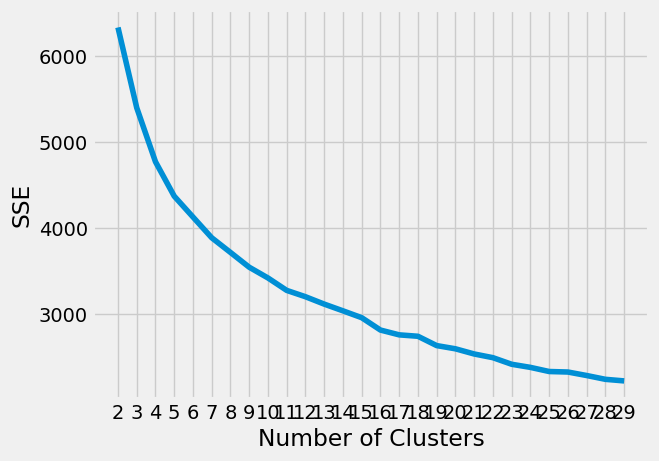

In [52]:
# Elbow curve to find optimal K 
kmeans_kwargs = {
    "init": "random",
    "n_init": 30,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
silhouette_avg = {}
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    cluster_labels = kmeans.fit_predict(data)
    sse.append(kmeans.inertia_)
    silhouette_avg[k] = silhouette_score(data, cluster_labels)
    

print(silhouette_avg)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 30), sse)
plt.xticks(range(2, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


In [53]:
kmeans = KMeans(
    init="random",
    n_clusters=9,
    n_init=30,
    max_iter=300,
    random_state=42
)
clusters = kmeans.fit_predict(data) 
clusters

array([2, 2, 2, 4, 7, 8, 2, 2, 2, 4, 4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 5,
       8, 6, 2, 2, 8, 0, 0, 6, 2, 0, 6, 0, 2, 0, 8, 6, 6, 7, 6, 6, 6, 6,
       0, 0, 7, 0, 6, 8, 0, 0, 0, 0, 0, 0, 0, 1, 8, 2, 6, 2, 0, 6, 0, 0,
       0, 6, 7, 1, 1, 0, 0, 7, 0, 0, 0, 7, 0, 8, 4, 7, 8, 4, 7, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 7, 0, 2, 7, 7, 7, 2, 7, 7, 4, 4, 7, 4, 4, 4, 8,
       2, 0, 0, 0, 7, 7, 2, 5, 8, 7, 8, 7, 5, 7, 7, 7, 8, 8, 8, 8, 8, 8,
       5, 8, 5, 8, 5, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 7, 1, 1, 3, 1, 1, 1,
       3, 1, 0, 1, 0, 1, 6, 1, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3,
       1, 1, 1, 1, 6, 1, 1, 6, 6, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 7,
       2, 2, 2, 7, 2, 7, 7, 2, 4, 7, 7, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 7,
       7, 4, 2, 8, 2, 7, 2, 7, 2, 7, 6, 7, 0, 7, 7, 5, 0, 7, 6, 2, 0, 2,
       6, 6, 6, 6, 6, 0, 7, 1, 1, 6, 6, 6, 6, 6, 6, 0, 6, 7, 7, 7, 8, 7,
       6, 5, 5, 8, 5, 5, 5, 7, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 1, 1,
       1, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 8, 7, 5,

<Axes: >

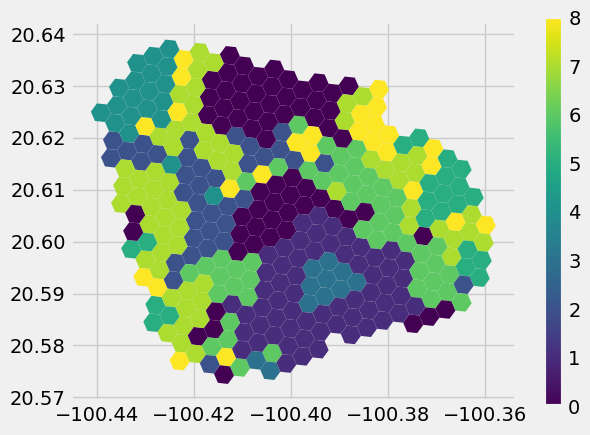

In [54]:
hex_mrg['cluster'] = clusters
hex_mrg.plot('cluster', legend=True)

In [55]:
hex_mrg.groupby('cluster').mean(numeric_only=True)

,nse_idx,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn,denue_count,denue_jobs,...,pct_recreativomean,pct_servmean,area_in_meters,number_intersections,max_time,max_entretenimiento,max_comercio,max_servicios comunitarios,max_escuelas,idx_sum
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.200170,11.990488,86.547383,0.626589,0.213303,0.638598,0.148099,0.966241,2868.149255,24590.554943,...,0.001710,0.107016,76.249486,17.800000,24.933242,21.003227,5.910107,20.140926,13.763252,12.982412
1,0.366558,12.370419,60.003235,0.567010,0.158248,0.603494,0.221591,0.966397,7901.772476,63968.556187,...,0.003682,0.268003,96.798830,13.116667,21.378248,13.779138,3.987464,12.547506,18.592184,13.293050
2,0.200967,11.711211,29.900687,0.598077,0.197508,0.629932,0.144783,0.966511,2267.682896,25874.285948,...,0.003554,0.218402,310.206871,4.472222,40.254815,24.673009,10.818152,39.724127,26.777337,11.696308
3,0.640788,13.450830,34.365826,0.559688,0.140313,0.624363,0.235323,0.966383,9596.235919,74195.896837,...,0.026122,0.438629,95.753605,10.181818,24.286419,11.355667,5.715417,14.730101,23.484782,13.189581
4,-1.215728,2.986033,1.255810,0.161450,0.486057,0.184254,0.029689,0.331602,1045.319439,18399.165048,...,0.000000,0.205486,384.945828,0.250000,65.921802,32.683624,22.752726,65.921802,44.376847,8.570397
5,0.666993,12.817222,56.158328,0.774924,0.209912,0.611582,0.133051,0.973998,402.677337,4188.934203,...,0.001489,0.041176,89.246587,12.636364,54.943839,45.863426,14.267157,54.231236,50.640900,8.758331
6,0.630736,13.377286,38.869286,0.748283,0.167457,0.606871,0.225672,0.971283,3615.816551,34347.475538,...,0.005605,0.302809,114.926996,10.062500,25.933001,20.868133,8.300005,22.537714,18.767757,12.777961
7,-0.010715,11.433408,65.942190,0.597918,0.244120,0.624520,0.131361,0.961224,1739.457230,18535.862095,...,0.001356,0.097232,77.719138,15.666667,42.218866,24.988903,9.499896,41.218143,27.500619,11.685037
8,0.070379,10.848794,20.755844,0.601652,0.225031,0.580571,0.117475,0.886880,1236.937860,13605.420369,...,0.002839,0.098554,109.730549,5.230769,40.278849,30.825776,16.068931,39.140328,29.760516,10.681544


In [56]:
hex_mrg.groupby('cluster').count()

,hex_id_9,geometry,nse_idx,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn,...,pct_recreativomean,pct_servmean,area_in_meters,number_intersections,max_time,max_entretenimiento,max_comercio,max_servicios comunitarios,max_escuelas,idx_sum
cluster,,,,,,,,,,,,,,,,,,,,,
0,65,65,65,65,65,65,65,65,65,65,...,65,65,65,65,65,65,65,65,65,65
1,60,60,60,60,60,60,60,60,60,60,...,60,60,60,60,60,60,60,60,60,60
2,36,36,36,36,36,36,36,36,36,36,...,36,36,36,36,36,36,36,36,36,36
3,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
4,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
5,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22
6,48,48,48,48,48,48,48,48,48,48,...,48,48,48,48,48,48,48,48,48,48
7,63,63,63,63,63,63,63,63,63,63,...,63,63,63,63,63,63,63,63,63,63
8,26,26,26,26,26,26,26,26,26,26,...,26,26,26,26,25,25,25,25,25,25


In [57]:
hex_hm = hex_mrg.copy()
'''hex_hm = hex_hm.drop(columns=['denue_jobs_>_11','area_m2',
                               'denue_jobs','area_pob','denue_count',
                              'dens_pob_ha','wgt_imn','pct_jobs_>_11'])'''
hex_hm = hex_hm.groupby('cluster').mean(numeric_only=True)
# hex_hm = hex_hm.reset_index()

In [58]:
hex_hm.head(2)

,nse_idx,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn,denue_count,denue_jobs,...,pct_recreativomean,pct_servmean,area_in_meters,number_intersections,max_time,max_entretenimiento,max_comercio,max_servicios comunitarios,max_escuelas,idx_sum
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.200170,11.990488,86.547383,0.626589,0.213303,0.638598,0.148099,0.966241,2868.149255,24590.554943,...,0.001710,0.107016,76.249486,17.800000,24.933242,21.003227,5.910107,20.140926,13.763252,12.982412
1,0.366558,12.370419,60.003235,0.567010,0.158248,0.603494,0.221591,0.966397,7901.772476,63968.556187,...,0.003682,0.268003,96.798830,13.116667,21.378248,13.779138,3.987464,12.547506,18.592184,13.293050


In [59]:
scaler = StandardScaler()
scaled_cluster = scaler.fit_transform(hex_hm)

In [60]:
hex_hm.mean(axis=0)

nse_idx                           0.172239
graproes                         11.220632
dens_pob_ha                      43.755399
auto_viv                          0.581732
pct_0_17                          0.226883
pct_18_59                         0.567132
pct_60_mas                        0.154116
wgt_imn                           0.887836
denue_count                    3408.227663
denue_jobs                    30856.239019
denue_jobs_>_11               20072.518468
pct_jobs_>_11                     0.679537
pct_BANQUETA                      0.817303
pct_ALUMPUB                       0.597199
pct_RAMPAS                        0.196214
pct_ARBOLES                       0.542889
pct_CICLOVIA                      0.029825
ndvi_mean                         0.153380
temperature_mean                  0.259891
ndmi_diff                         0.083956
pct_openspace                     0.612058
street_dens                       0.663978
pct_comerciomean                  0.129794
pct_equipme

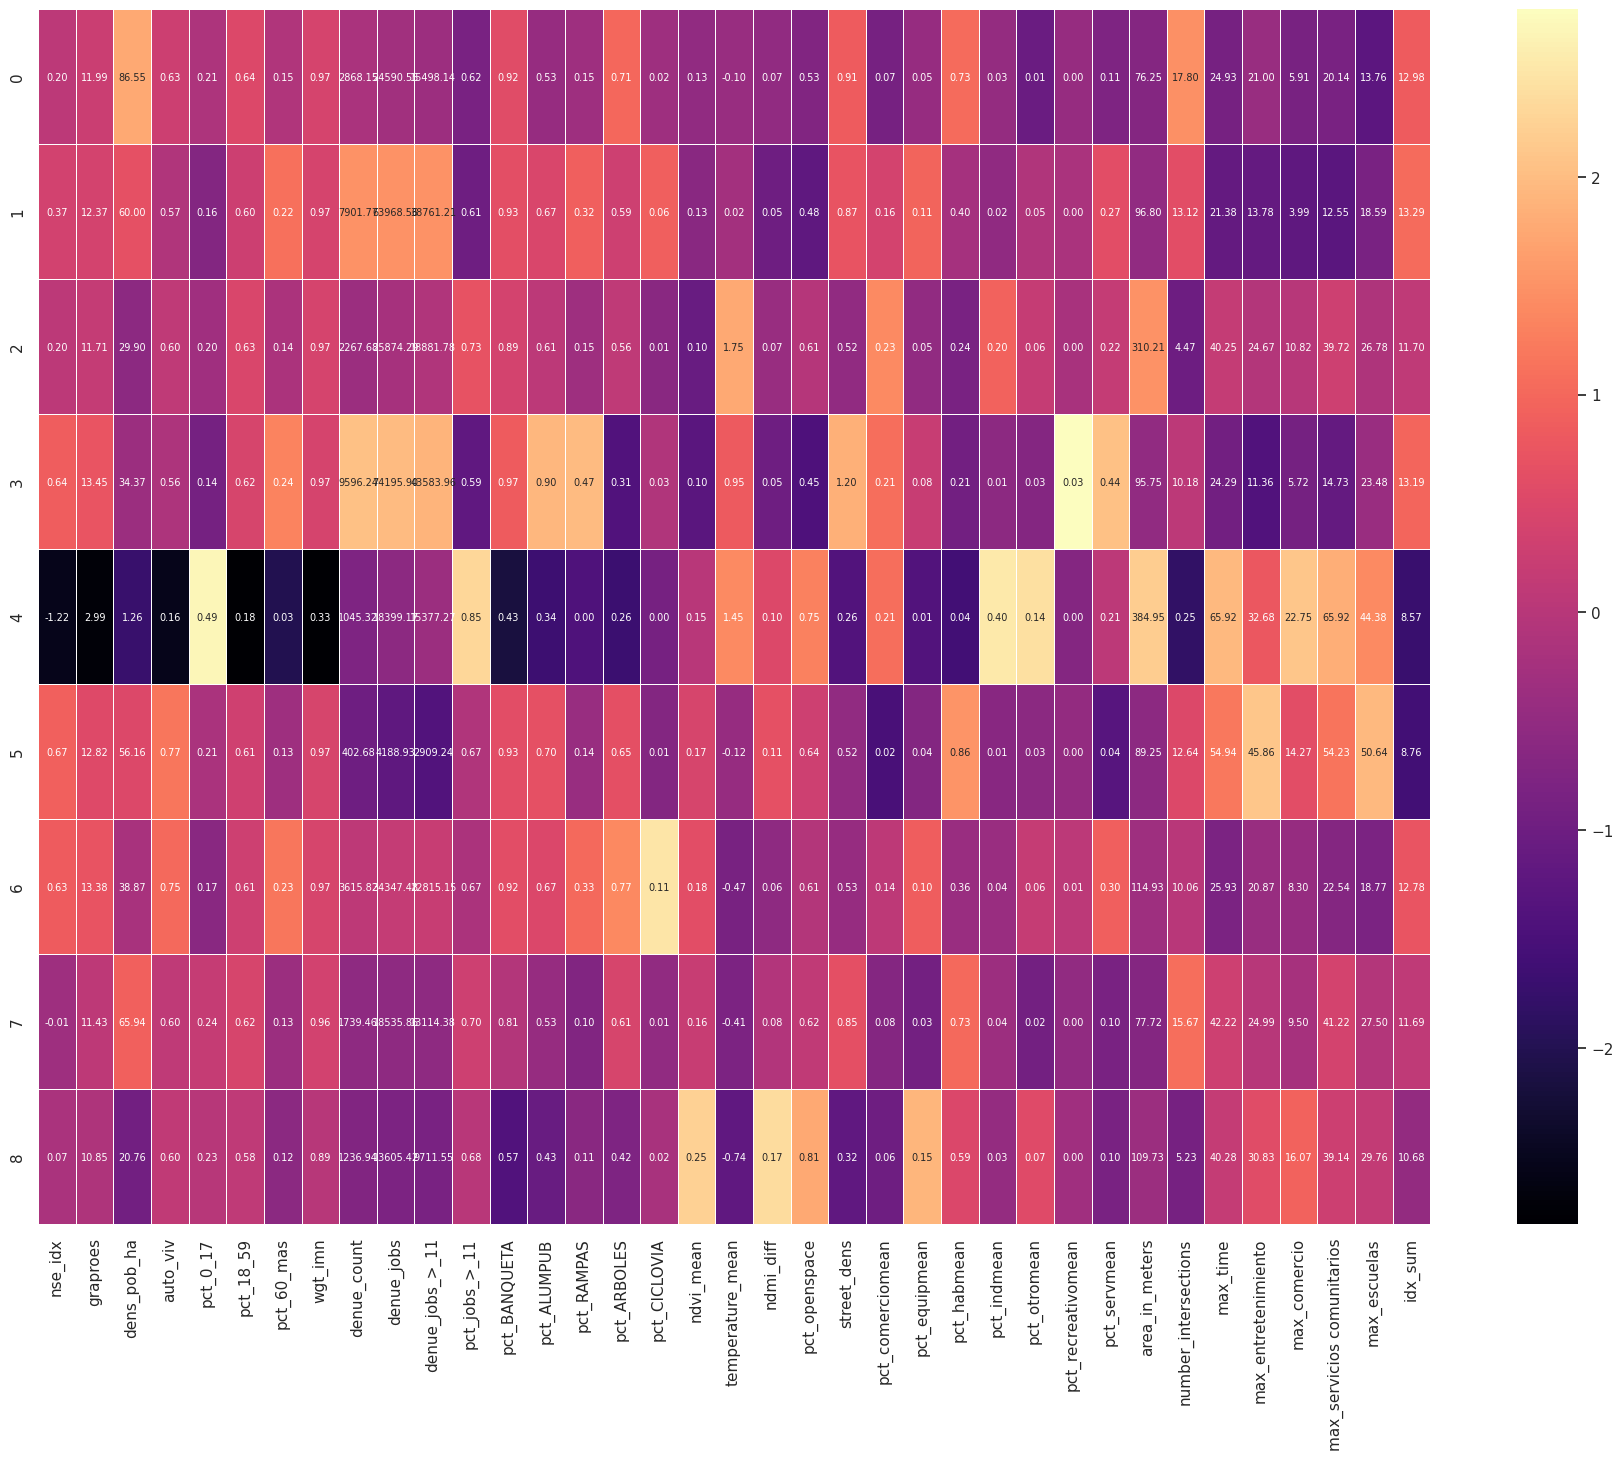

In [61]:
sns.set (rc = {'figure.figsize':(20,15)})

sns.heatmap(scaled_cluster, annot=hex_hm, 
            xticklabels=hex_hm.columns,
           fmt=".2f", linewidth=.5, cmap="magma",
           annot_kws={'size': 7})

plt.savefig('../../../output/figures/Distrito_QRO/Clusters_Statistical_Behaviour.png')

In [62]:
hex_mrg.to_file(f'{data_dir}hex_clusters.geojson')